## Task

In this HW, you will to do image in-painting using autoencoders.

Image In-painting is a task where you give a corrupted or incomplete image as an input and the output is the completed image.

We will do image in-painting on CIFAR10 dataset. The code below can help you generate random corrupted images.

Your task is to construct and train an autoencoder on this dataset for image in-painting. Finally as evaluation, show 10 random examples from testset and how your model performs on them.


Hint: Using a u-net like structure might help.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from tqdm import tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
    super().__init__(path, train, download = True)
    self.n_classes = 10
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [6]:
Trainset = Dataset('./data')
Testset = Dataset('./data', train=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48947115.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
def show_imgs(masked_image, mask, original_image):
  f, axs = plt.subplots(1,3)
  axs[0].imshow(np.transpose(masked_image.numpy(), (1,2,0)))
  axs[0].set_title("Masked Image")
  axs[1].imshow(np.transpose(mask.numpy(), (1,2,0)))
  axs[1].set_title("Mask")
  axs[2].imshow(np.transpose(original_image.numpy(), (1,2,0)))
  axs[2].set_title("Original Image")

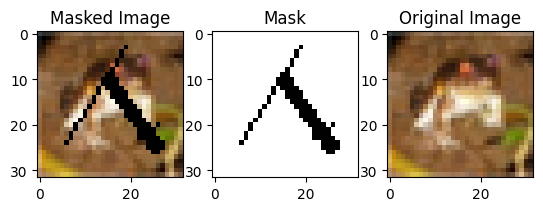

In [8]:
show_imgs(*Trainset[0])

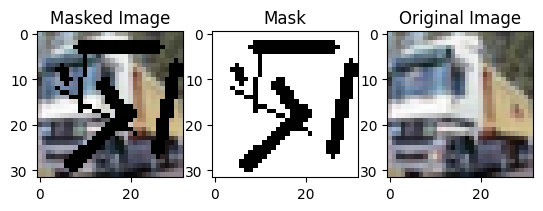

In [9]:
show_imgs(*Trainset[1])

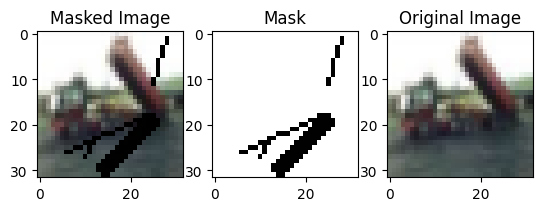

In [10]:
show_imgs(*Trainset[2])

In [11]:
batch_size = 128
Trainset, Valset = torch.utils.data.random_split(Trainset, [int(len(Trainset)*0.8), len(Trainset)-int(len(Trainset)*0.8)])
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Valloader = torch.utils.data.DataLoader(Valset, batch_size = batch_size, shuffle = False)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [12]:
Trainloader.dataset[0][0].shape

torch.Size([3, 32, 32])

## Model Archeticture
I used a similar archeticture to this image, however, I am using linear layers at the end of the encoder and the beginning of the decoder.

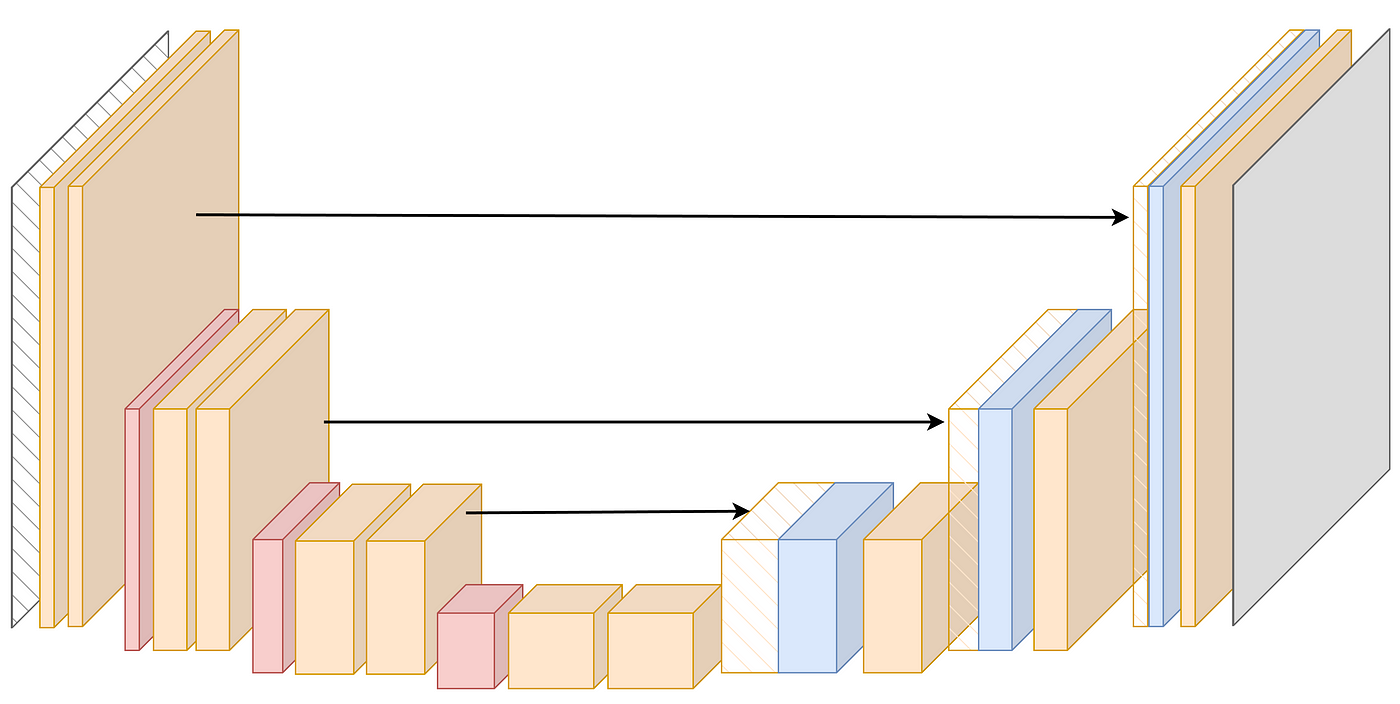

### Draft models

#### First model
Skip connection is Addition

In [58]:
# class ImageInPainting(nn.Module):
#     def __init__(self, z_dim):
#         super(ImageInPainting, self).__init__()
#         # Activation functions
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
#         # pooling
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # encoder arch
#         self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.norm1 = nn.BatchNorm2d(64)
#         self.encoder_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.norm2 = nn.BatchNorm2d(128)
#         self.encoder_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
#         self.norm3 = nn.BatchNorm2d(256)
#         self.encoder_linear1 = nn.Linear(in_features=256*4*4, out_features=1024)
#         self.encoder_linear2 = nn.Linear(in_features=1024, out_features=z_dim)

#         # decoder arch
#         self.decoder_linear1 = nn.Linear(in_features=z_dim, out_features=1024)
#         self.decoder_linear2 = nn.Linear(in_features=1024, out_features=256*4*4)
#         self.decoder_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
#         self.decoder_conv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
#         self.decoder_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1)

#     def encoder(self, x):  # incoming images will be 3 x 32 x 32
#         x1 = self.relu(self.norm1(self.encoder_conv1(x)))  # 64 x 32 x 32
#         x1 = self.maxpool(x1)  # 64 x 16 x 16
#         x2 = self.relu(self.norm2(self.encoder_conv2(x1)))  # 128 x 16 x 16
#         x2 = self.maxpool(x2)  # 128 x 8 x 8
#         x3 = self.relu(self.norm3(self.encoder_conv3(x2)))  # 256 x 8 x 8
#         x3 = self.maxpool(x3)  # 256 x 4 x 4
#         x = x3.view(-1, 256*4*4)
#         x = self.relu(self.encoder_linear1(x))
#         z = self.tanh(self.encoder_linear2(x))
#         return z, x1, x2, x3

#     def decoder(self, z, encoder_convs):
#         x = self.relu(self.decoder_linear1(z))
#         x = self.relu(self.decoder_linear2(x))
#         x = x.view(-1, 256, 4, 4)
#         x = self.relu(self.decoder_conv1(x))  # 128 x 8 x 8
#         x = x + encoder_convs[0]
#         x = self.relu(self.decoder_conv2(x))  # 64 x 16 x 16
#         x = x + encoder_convs[1]
#         x = self.decoder_conv3(x)  # 3 x 32 x 32
#         x = x + encoder_convs[2]
#         return x

#     def forward(self, x):
#         z, *encoder_convs = self.encoder(x)
#         x = self.decoder(z, encoder_convs)
#         return x

#### second model
Skip connection is Concatenation

In [85]:
# class ImageInPainting(nn.Module):
#     def __init__(self, z_dim):
#         super(ImageInPainting, self).__init__()
#         # Activation functions
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
#         # pooling
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # encoder arch
#         self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.norm1 = nn.BatchNorm2d(64)
#         self.encoder_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
#         self.norm2 = nn.BatchNorm2d(128)
#         self.encoder_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
#         self.norm3 = nn.BatchNorm2d(256)
#         self.encoder_linear1 = nn.Linear(in_features=256*4*4, out_features=1024)
#         self.encoder_linear2 = nn.Linear(in_features=1024, out_features=z_dim)

#         # decoder arch
#         self.decoder_linear1 = nn.Linear(in_features=z_dim, out_features=1024)
#         self.decoder_linear2 = nn.Linear(in_features=1024, out_features=256*4*4)
#         self.decoder_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
#         self.decoder_conv2 = nn.ConvTranspose2d(in_channels=128+256, out_channels=64, kernel_size=4, stride=2, padding=1)
#         self.decoder_conv3 = nn.ConvTranspose2d(in_channels=64+128, out_channels=3, kernel_size=4, stride=2, padding=1)
#         self.final_conv = nn.Conv2d(in_channels=3+64, out_channels=3, kernel_size=3, stride=1, padding=1)

#     def encoder(self, x):  # incoming images will be 3 x 32 x 32
#         x1 = self.relu(self.norm1(self.encoder_conv1(x)))  # 64 x 32 x 32
#         x1_pool = self.maxpool(x1)  # 64 x 16 x 16
#         x2 = self.relu(self.norm2(self.encoder_conv2(x1_pool)))  # 128 x 16 x 16
#         x2_pool = self.maxpool(x2)  # 128 x 8 x 8
#         x3 = self.relu(self.norm3(self.encoder_conv3(x2_pool)))  # 256 x 8 x 8
#         x3_pool = self.maxpool(x3)  # 256 x 4 x 4
#         x = x3_pool.view(-1, 256*4*4)
#         x = self.relu(self.encoder_linear1(x))
#         z = self.tanh(self.encoder_linear2(x))
#         return z, x3, x2, x1

#     def decoder(self, z, encoder_convs):
#         x = self.relu(self.decoder_linear1(z))
#         x = self.relu(self.decoder_linear2(x))
#         x = x.view(-1, 256, 4, 4)
#         x = self.relu(self.decoder_conv1(x))  # 128 x 8 x 8
#         x = torch.cat([x, encoder_convs[0]], dim=1)  # (128+256) x 8 x 8
#         x = self.relu(self.decoder_conv2(x))  # 64 x 16 x 16
#         x = torch.cat([x, encoder_convs[1]], dim=1)  # (64+128) x 16 x 16
#         x = self.decoder_conv3(x)  # 3 x 32 x 32
#         x = torch.cat([x, encoder_convs[2]], dim=1)  # (3+64) x 32 x 32
#         x = self.final_conv(x)  # 3 x 32 x 32
#         return x

#     def forward(self, x):
#         z, *encoder_convs = self.encoder(x)
#         x = self.decoder(z, encoder_convs)
#         return x

### final version

smaller deconv filters

In [63]:
class ImageInPainting(nn.Module):
    def __init__(self, z_dim):
        super(ImageInPainting, self).__init__()
        # Activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # pooling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.2)

        # encoder arch
        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(64)
        self.encoder_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(128)
        self.encoder_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm2d(256)
        self.encoder_linear1 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.encoder_linear2 = nn.Linear(in_features=1024, out_features=z_dim)

        # decoder arch
        self.decoder_linear1 = nn.Linear(in_features=z_dim, out_features=1024)
        self.decoder_linear2 = nn.Linear(in_features=1024, out_features=256*4*4)
        self.decoder_conv1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.decoder_conv2 = nn.ConvTranspose2d(in_channels=128+256, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.decoder_conv3 = nn.ConvTranspose2d(in_channels=64+128, out_channels=3, kernel_size=2, stride=2, padding=0)
        self.norm4 = nn.BatchNorm2d(3)
        self.final_conv = nn.Conv2d(in_channels=3+64, out_channels=3, kernel_size=3, stride=1, padding=1)

    def encoder(self, x):  # incoming images will be 3 x 32 x 32
        x1 = self.relu(self.norm1(self.encoder_conv1(x)))  # 64 x 32 x 32
        x1_pool = self.maxpool(x1)  # 64 x 16 x 16
        x2 = self.relu(self.norm2(self.encoder_conv2(x1_pool)))  # 128 x 16 x 16
        x2_pool = self.maxpool(x2)  # 128 x 8 x 8
        x3 = self.relu(self.norm3(self.encoder_conv3(x2_pool)))  # 256 x 8 x 8
        x3_pool = self.maxpool(x3)  # 256 x 4 x 4
        x = x3_pool.view(-1, 256*4*4)
        x = self.relu(self.encoder_linear1(x))
        # x = self.dropout(x)
        z = self.tanh(self.encoder_linear2(x))
        # z = self.dropout(z)
        return z, x3, x2, x1

    def decoder(self, z, encoder_convs):
        x = self.relu(self.decoder_linear1(z))
        # x = self.dropout(x)
        x = self.relu(self.decoder_linear2(x))
        # x = self.dropout(x)
        x = x.view(-1, 256, 4, 4)
        x = self.relu(self.norm2(self.decoder_conv1(x)))  # 128 x 8 x 8
        x = torch.cat([x, encoder_convs[0]], dim=1)  # (128+256) x 8 x 8
        x = self.relu(self.norm1(self.decoder_conv2(x)))  # 64 x 16 x 16
        x = torch.cat([x, encoder_convs[1]], dim=1)  # (64+128) x 16 x 16
        x = self.relu(self.norm4(self.decoder_conv3(x)))  # 3 x 32 x 32
        x = torch.cat([x, encoder_convs[2]], dim=1)  # (3+64) x 32 x 32
        x = self.final_conv(x)  # 3 x 32 x 32
        return x

    def forward(self, x):
        z, *encoder_convs = self.encoder(x)
        x = self.decoder(z, encoder_convs)
        return x

### Sanity check

In [64]:
## sanity check
Z = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch = next(iter(Trainloader))
batch = batch[0].to(device)
print(batch.shape)
image_inpainting_model = ImageInPainting(z_dim=Z).to(device)
y_hat = image_inpainting_model(batch)
print(y_hat.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])


# Training loop

In [65]:
learning_rate = 1e-3
num_epochs = 25
optimizer = torch.optim.Adam(image_inpainting_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [66]:
train_losses = []
val_losses = []


for epoch in range(num_epochs):

    image_inpainting_model.train()
    total_loss = 0
    for batch in tqdm(Trainloader):
        corrupted_img, _, correct_image  = batch
        corrupted_img, correct_image = corrupted_img.to(device), correct_image.to(device)

        y_hat = image_inpainting_model(corrupted_img)
        loss = criterion(y_hat, correct_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(Trainloader)
    train_losses.append(epoch_loss)
    # validation loop
    image_inpainting_model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for batch in tqdm(Valloader):
        corrupted_img, _, correct_image  = batch
        corrupted_img, correct_image = corrupted_img.to(device), correct_image.to(device)
        y_hat = image_inpainting_model(corrupted_img)
        val_loss = criterion(y_hat, correct_image)
        total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(Valloader)
    val_losses.append(epoch_val_loss)

    print(f"\nEpoch: {epoch+1}/{num_epochs} Training loss: {epoch_loss:.4f} \t Validation loss: {epoch_val_loss}")


100%|██████████| 79/79 [00:04<00:00, 16.42it/s]



Epoch: 1/25 Training loss: 0.0163 	 Validation loss: 0.05134601329889479


100%|██████████| 79/79 [00:05<00:00, 13.91it/s]



Epoch: 2/25 Training loss: 0.0049 	 Validation loss: 0.060119345359787156


100%|██████████| 79/79 [00:04<00:00, 16.69it/s]



Epoch: 3/25 Training loss: 0.0041 	 Validation loss: 0.06701023499422436


100%|██████████| 79/79 [00:05<00:00, 13.94it/s]



Epoch: 4/25 Training loss: 0.0037 	 Validation loss: 0.06670784403251696


100%|██████████| 79/79 [00:04<00:00, 16.37it/s]



Epoch: 5/25 Training loss: 0.0036 	 Validation loss: 0.07144673074348064


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]



Epoch: 6/25 Training loss: 0.0034 	 Validation loss: 0.06464547715798209


100%|██████████| 79/79 [00:04<00:00, 16.55it/s]



Epoch: 7/25 Training loss: 0.0031 	 Validation loss: 0.06096446947960914


100%|██████████| 79/79 [00:05<00:00, 13.96it/s]



Epoch: 8/25 Training loss: 0.0030 	 Validation loss: 0.06016530766140057


100%|██████████| 79/79 [00:04<00:00, 16.46it/s]



Epoch: 9/25 Training loss: 0.0029 	 Validation loss: 0.060364366237875784


100%|██████████| 79/79 [00:05<00:00, 14.06it/s]



Epoch: 10/25 Training loss: 0.0030 	 Validation loss: 0.05451897442152229


100%|██████████| 79/79 [00:04<00:00, 16.55it/s]



Epoch: 11/25 Training loss: 0.0028 	 Validation loss: 0.057555952545585515


100%|██████████| 79/79 [00:05<00:00, 14.05it/s]



Epoch: 12/25 Training loss: 0.0026 	 Validation loss: 0.05027597133494631


100%|██████████| 79/79 [00:04<00:00, 16.33it/s]



Epoch: 13/25 Training loss: 0.0029 	 Validation loss: 0.052823588393534286


100%|██████████| 79/79 [00:05<00:00, 13.82it/s]



Epoch: 14/25 Training loss: 0.0027 	 Validation loss: 0.05195737554679943


100%|██████████| 79/79 [00:04<00:00, 16.44it/s]



Epoch: 15/25 Training loss: 0.0026 	 Validation loss: 0.050135805071154727


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]



Epoch: 16/25 Training loss: 0.0026 	 Validation loss: 0.05304625781276558


100%|██████████| 79/79 [00:04<00:00, 16.44it/s]



Epoch: 17/25 Training loss: 0.0024 	 Validation loss: 0.0506115948569171


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]



Epoch: 18/25 Training loss: 0.0024 	 Validation loss: 0.05070666893373562


100%|██████████| 79/79 [00:04<00:00, 16.38it/s]



Epoch: 19/25 Training loss: 0.0023 	 Validation loss: 0.05281681784346134


100%|██████████| 79/79 [00:05<00:00, 14.04it/s]



Epoch: 20/25 Training loss: 0.0024 	 Validation loss: 0.04898439701410789


100%|██████████| 79/79 [00:04<00:00, 16.52it/s]



Epoch: 21/25 Training loss: 0.0024 	 Validation loss: 0.055156303734719


100%|██████████| 79/79 [00:05<00:00, 14.39it/s]



Epoch: 22/25 Training loss: 0.0023 	 Validation loss: 0.05650419359908828


100%|██████████| 79/79 [00:04<00:00, 16.70it/s]



Epoch: 23/25 Training loss: 0.0022 	 Validation loss: 0.05002626154241683


100%|██████████| 79/79 [00:05<00:00, 14.85it/s]



Epoch: 24/25 Training loss: 0.0022 	 Validation loss: 0.05581634722744362


100%|██████████| 79/79 [00:04<00:00, 16.35it/s]


Epoch: 25/25 Training loss: 0.0020 	 Validation loss: 0.055845092086097864


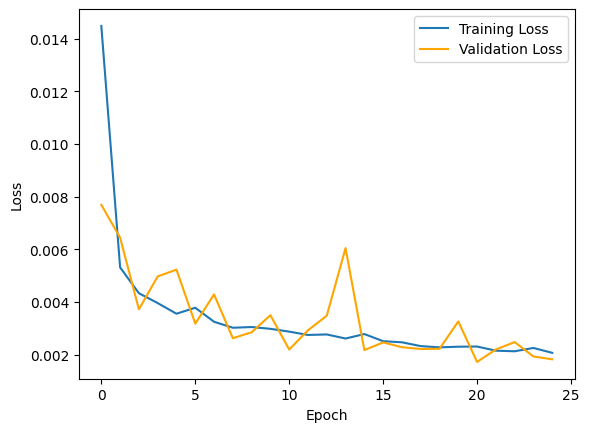

In [46]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.plot(val_losses, label='Validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final Evalution on test dataset

In [106]:
# print(Testloader.dataset[0])

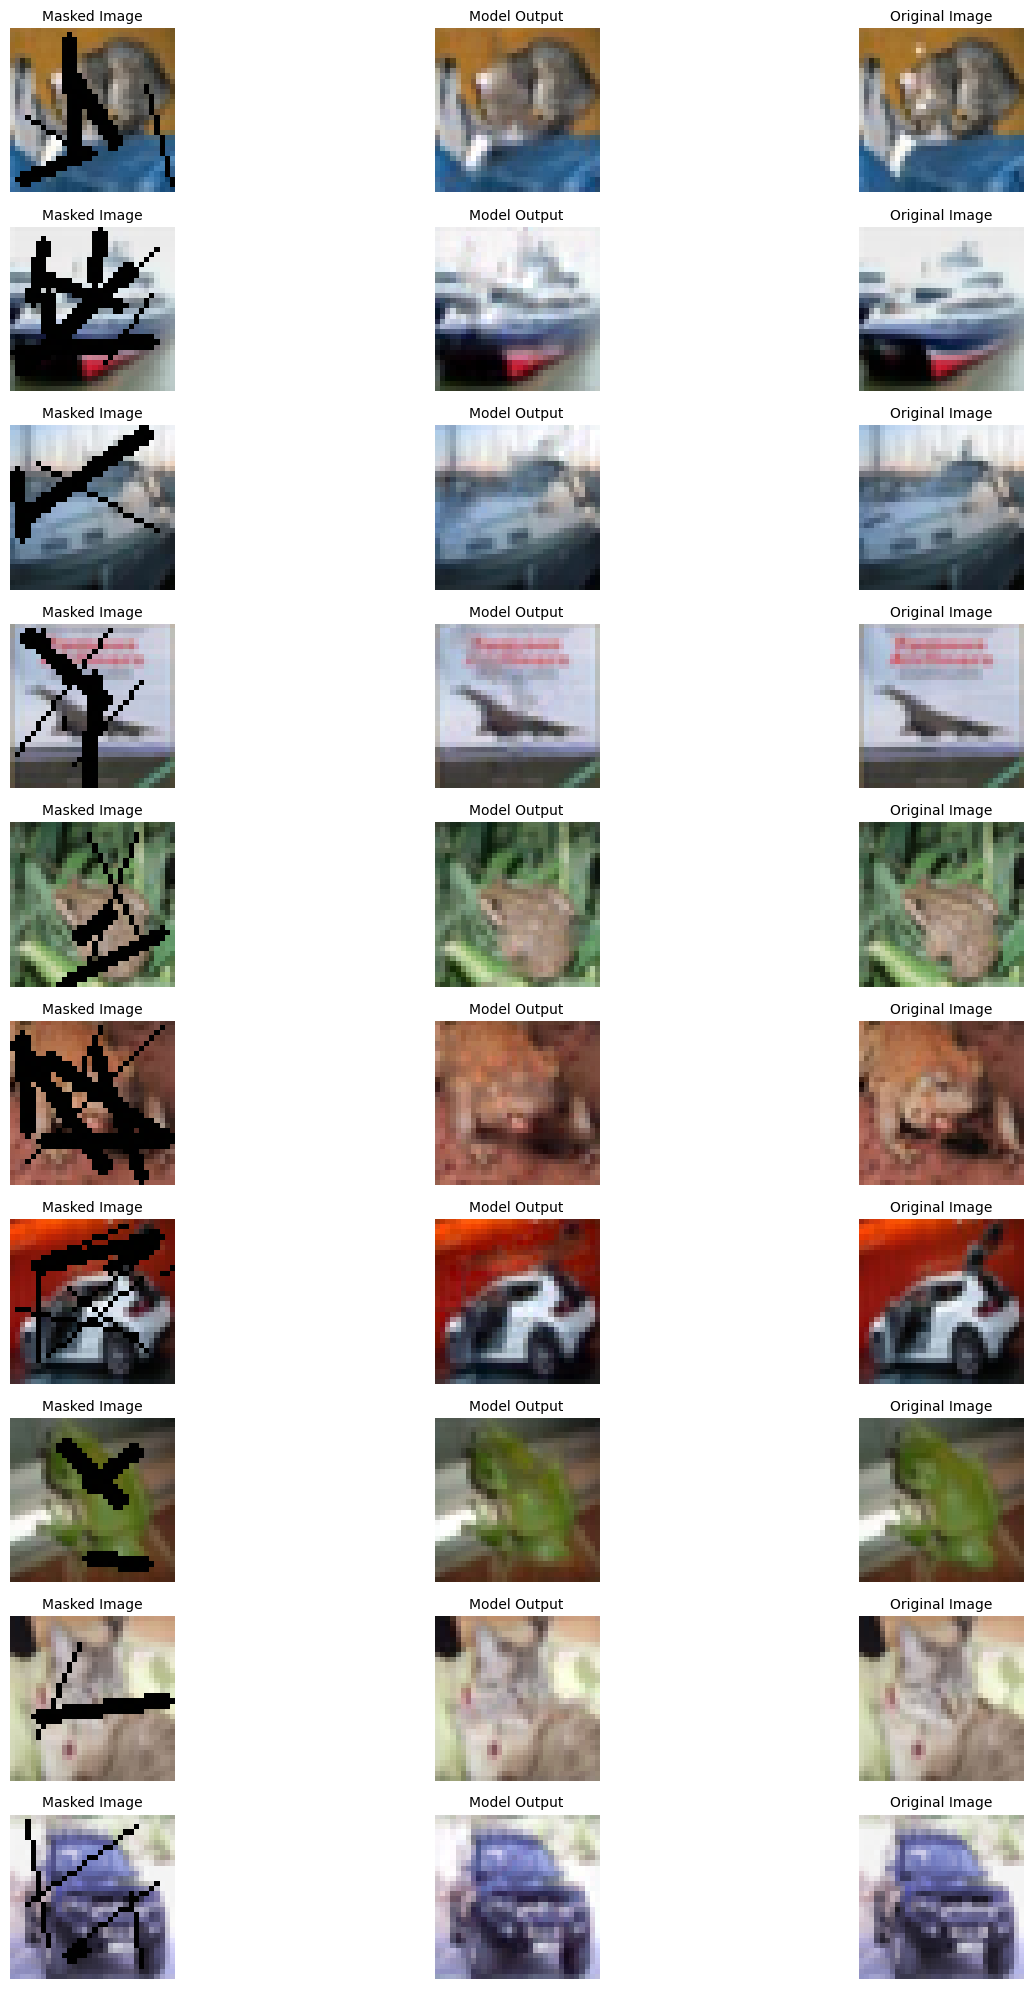

In [47]:
image_inpainting_model.eval()  # Set the model to evaluation mode
fig, axs = plt.subplots(10, 3, figsize=(15, 20))
# fig.suptitle("Masked Image, Model Output, and Original Image", fontsize=16)

with torch.no_grad():  # Disable gradient computation
    for i in range(10):
        masked_image, _, original_image = Testloader.dataset[i]
        masked_image_input = masked_image.unsqueeze(0).to(device)
        output = image_inpainting_model(masked_image_input)

        masked_image = masked_image.cpu().numpy()
        output_image = output.squeeze(0).cpu().numpy()
        original_image = original_image.numpy()

        masked_image = np.transpose(masked_image, (1, 2, 0))
        output_image = np.transpose(output_image, (1, 2, 0))
        original_image = np.transpose(original_image, (1, 2, 0))

        output_image = np.clip(output_image, 0, 1)

        axs[i, 0].imshow(masked_image)
        axs[i, 0].set_title("Masked Image", fontsize=10)
        axs[i, 0].axis('off')

        axs[i, 1].imshow(output_image)
        axs[i, 1].set_title("Model Output", fontsize=10)
        axs[i, 1].axis('off')

        axs[i, 2].imshow(original_image)
        axs[i, 2].set_title("Original Image", fontsize=10)
        axs[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Discussion

***What I have tried:***

I have tried three archetictures each with minor changes but with a positive impact. The difference is that: The first model I was using skip connections using Addition, which was working well but then in the second and third models, I tried to make skip connections using concatenation and the results were better. The other difference is that I changed the filter parameters of the transposed convolution layers to be smaller.
(kernel_size=4, stride=2, padding=1 -> kernel_size=3, stride=1, padding=1)
I found that smaller filters better, but that may not be always the case.
Other than these changes, the 3 models follow a similar simple archeticture that is inspired from the u-net archeticture where the encoder has 3 convolution blocks (conv layer -> batch norm -> relu -> max pool) followed by 2 linear layers. The decoder has 2 linear layers followed by 3 deconvolution blocks (transposed Conv -> batch norm -> relu -> skip connection with an encoder conv block) then finally followed by a final convultion to make the channels back to 3.

***What I haven't tried and that could help:***

I have used a mox pooling after each convolution layer, which might be too much especially when dealing with small (32 x 32) images. So maybe I will get better results if I make max pooling after every 2 conv layers and increase the # of conv layers a bit.